In [2]:
!pip install numpy==1.24.4
!pip install --upgrade scikit-learn
!pip install pytorch-tabular[all] shap

  Using cached numpy-1.24.4.tar.gz (10.9 MB)
  Installing build dependencies ...   Installing build dependencies ... -done
done
  Getting requirements to build wheel ...   Getting requirements to build wheel ... -error
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> [32 lines of output]
      Traceback (most recent call last):
        File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 389, in <module>
          main()
          ~~~~^^
        File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 373, in main
          json_out["return_val"] = hook(**hook_input["kwargs"])
                                   ~~~~^^^^^^^^^^^^^^^^^^^^^^^^
        File "/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site

In [3]:
import pickle
import pandas as pd
import os
df = pd.read_pickle('/Users/Joschua/Desktop/XAI/XAImitKAI/VIZ-XAI-OpenDataGermany/trainingData.pkl')
df

,luftrtng,p_poli,p_apo,v_breitb50,v_breitb1000,p_nelade,p_selade,p_harzt,bev_dicht,bev_entw,...,Green_Areas,Water_Bodies,Landuse,Building_Types,All_Buildings,Buildings_With_Height_Levels,Health,Finance,All_Highways,Cycleways
0,9.59,3.20,2.69,99.520715,96.960895,2.841364,5.456455,2.215,1631.41,0.91,...,4,0,17,2051,8068,8070,72,45,2117,1
1,7.81,3.09,2.52,98.489685,93.469684,3.211509,4.912096,2.060,2087.80,-0.02,...,37,7,387,2553,4635,4670,199,77,7615,82
2,5.55,4.22,3.34,97.180070,88.940276,3.921645,6.579440,2.470,1018.23,0.16,...,88,66,160,3709,7159,7194,202,93,8225,694
3,8.01,3.08,2.81,98.309014,95.729833,4.538864,5.322970,2.835,1109.43,0.04,...,8,0,64,357,538,539,36,24,1628,7
4,13.78,6.98,5.67,98.693970,97.258949,4.731183,6.356069,3.885,193.27,-0.16,...,0,0,17,152,221,221,13,6,787,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10949,4.57,8.17,2.85,82.092098,0.625355,9.362754,3.797101,2.370,243.99,0.18,...,0,0,1,5,10,10,2,2,74,1
10950,3.78,6.77,7.41,84.722222,0.000000,7.145333,5.996667,7.250,27.78,-2.93,...,0,0,0,0,0,0,0,0,13,0
10951,3.89,6.50,6.28,30.134933,3.748126,7.882192,7.086575,2.780,88.14,-0.07,...,0,1,7,1,17,17,1,0,136,0
10955,6.89,14.71,9.40,80.686695,0.000000,13.170400,16.332000,1.790,63.97,-2.21,...,0,1,0,0,7,7,0,1,10,0


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models.ft_transformer.config import FTTransformerConfig
from pytorch_lightning.callbacks import Callback

In [5]:
# Annahme: letzte Spalte ist das Ziel
target_col = "preis_miet_best"
# 3) Alle Spalten außer Ziel in numerische Form wandeln (Strings → NaN)
df_numeric = df.copy()
for col in df_numeric.columns:
    if col == target_col:
        continue
    # Versuche jeden Kolonnenwert in float zu konvertieren
    df_numeric[col] = pd.to_numeric(df_numeric[col], errors='coerce')

# 4) Nur die reinen numerischen Spalten behalten (incl. Ziel)
#    alle Kolonnen, die nach .to_numeric keine NaNs in Target, und dtype number
numeric_cols = df_numeric.select_dtypes(include=['number']).columns.tolist()
assert target_col in numeric_cols, "Zielspalte wird nicht als numerisch erkannt!"
feature_cols = [c for c in numeric_cols if c != target_col]

df_clean = df_numeric[feature_cols + [target_col]].dropna()
# Train-/Valid-Split
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df_clean, test_size=0.2, random_state=42)

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models.ft_transformer.config import FTTransformerConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_lightning.callbacks import Callback

# ==== Datenkonfiguration ====
data_config = DataConfig(
    target=[target_col],
    continuous_cols=feature_cols,
    normalize_continuous_features=True,
)

# ==== Modellkonfiguration ====
model_config = FTTransformerConfig(
    task="regression",
    input_embed_dim=64, # Dimension der Einbettungsvektoren für Features (innerhalb des Transformers)
    num_attn_blocks=5, # Anzahl der Transformer-Blöcke (Schichten)
    num_heads=8, # Anzahl der Attention-Köpfe pro Block
    transformer_head_dim=None,
    attn_dropout=0.05, # Dropout-Raten in den jeweiligen Komponenten, um Overfitting zu reduzieren
    add_norm_dropout=0.05,
    ff_dropout=0.1,
    learning_rate=0.0003019951720402019 # Lernrate, die zuvor bereits optimiert wurde
)

# ==== Trainingskonfiguration ====
trainer_config = TrainerConfig(
    batch_size=256,
    max_epochs=100,
    early_stopping="valid_mean_squared_error", # Stoppt Training, wenn sich der Validierungs-MSE nicht mehr verbessert
    accelerator="gpu",
    devices=1,
    precision=16,
)

optimizer_config = OptimizerConfig(
    optimizer="AdamW", # Beliebter Optimierer mit Gewichts-Decays-Korrektur
    lr_scheduler="CosineAnnealingLR", # Lernraten-Scheduler, der die Lernrate zyklisch abfallen lässt
    lr_scheduler_params={
        "T_max": 20,
        "eta_min": 1e-6
    }
)

# ==== Modell erstellen und trainieren ====
tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)

tabular_model.fit(
    train=train_df,
    validation=valid_df,
    callbacks=[PrintRMSECallback()],
)

# ================================
# RMSE manuell berechnen
# ================================

from sklearn.metrics import mean_squared_error
import numpy as np
import os, json, time

# Eval-Modus aktivieren
tabular_model.model.eval()

# Input-Features und Target extrahieren
X_val = valid_df[feature_cols].values
y_val = valid_df[target_col].values

# In Torch-Tensor konvertieren
X_tensor = torch.tensor(X_val, dtype=torch.float32)

# Vorhersage direkt über das Modell
with torch.no_grad():
    y_pred_tensor = tabular_model.model(X_tensor)

# RMSE berechnen
y_pred = y_pred_tensor.numpy().squeeze()
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"\n✅ Finaler RMSE: {rmse:.4f}")

# Ergebnis speichern
os.makedirs("results", exist_ok=True)
run_id = f"run_{int(time.time())}"

result = {
    "run_id": run_id,
    "rmse": rmse,
    "learning_rate": model_config.learning_rate,
    "num_heads": model_config.num_heads,
    "num_attn_blocks": model_config.num_attn_blocks,
    "embed_dim": model_config.input_embed_dim
}

with open(f"results/{run_id}.json", "w") as f:
    json.dump(result, f, indent=2)

2025-06-29 00:07:58,632 - {pytorch_tabular.tabular_model:146} - INFO - Experiment Tracking is turned off

Seed set to 42


2025-06-29 00:07:58,650 - {pytorch_tabular.tabular_model:548} - INFO - Preparing the DataLoaders

2025-06-29 00:07:58,658 - {pytorch_tabular.tabular_datamodule:522} - INFO - Setting up the datamodule for          
regression task

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabular/tabular_datamodule.py:386: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.32476392 -0.32476392 -0.32476392 ... -0.32476392 -0.32476392
  0.63687785]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, self.config.continuous_cols] = self.scaler.fit_transform(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabular/tabular_datamodule.py:386: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.32476392 -0.32476392 -0.32476392 ... -0.32476392 -0.32476392
  0.63687785]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, self.config.continuous_cols] = self.scaler.fit_transform(
/Library/Frameworks/Python.framework/Ver

2025-06-29 00:07:58,775 - {pytorch_tabular.tabular_model:599} - INFO - Preparing the Model: FTTransformerModel

2025-06-29 00:07:58,897 - {pytorch_tabular.tabular_model:342} - INFO - Preparing the Trainer

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning_fabric/connector.py:571: `precision=16` is supported for historical reasons but its usage is discouraged. Please set your precision to 16-mixed instead!
Using 16bit Automatic Mixed Precision (AMP)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


2025-06-29 00:07:58,936 - {pytorch_tabular.tabular_model:678} - INFO - Training Started

┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name             ┃ Type                  ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ _backbone        │ FTTransformerBackbone │  902 K │ train │
│ 1 │ _embedding_layer │ Embedding2dLayer      │ 13.1 K │ train │
│ 2 │ _head            │ LinearHead            │     65 │ train │
│ 3 │ loss             │ MSELoss               │      0 │ train │
└───┴──────────────────┴───────────────────────┴────────┴───────┘

Trainable params: 916 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 916 K                                                                                                
Total estimated model params size (MB): 3                                                                          
Modules in train mode: 104                                                                                         
Modules in eval mode: 0

Output()

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683:
UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be 
used.
  warnings.warn(warn_msg)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/amp/autocast_mode.py:266: 
UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/trainer/connector
s/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider 
increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_lightning/loops/fit_loop.py
:298: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a
lower value for log_every_n_steps if you want to see logs for the training epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


2025-06-29 00:58:47,545 - {pytorch_tabular.tabular_model:689} - INFO - Training the model completed

2025-06-29 00:58:47,556 - {pytorch_tabular.tabular_model:1539} - WARNING - No best model available to load.        
Checkpoint Callback needs to be enabled for this to work

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabular/tabular_datamodule.py:390: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.32476392 -0.32476392 -0.32476392 ...  0.15605697 -0.32476392
 -0.32476392]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, self.config.continuous_cols] = self.scaler.transform(data.loc[:, self.config.continuous_cols])
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/pytorch_tabular/tabular_datamodule.py:390: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.32476392 -0.32476392 -0.32476392 ...  0.15605697 -0.32476392
 -0.32476392]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data.loc[:, self.config.continuous_cols] = self.scaler.transform(data.loc


✅ Finaler RMSE: 0.4720


In [17]:
import glob, json

# 1) Alle Run-JSONs laden
files = glob.glob("results/run_*.json")
runs  = [json.load(open(f)) for f in files]

# 2) Besten RMSE finden
best = min(runs, key=lambda x: x["rmse"])
print(f"Anzahl geloggter Runs: {len(runs)}")
print(f"Beste Run-ID:  {best['run_id']}")
print(f"Beste RMSE:    {best['rmse']:.4f}")

Anzahl geloggter Runs: 2
Beste Run-ID:  run_1751151533
Beste RMSE:    0.4720


In [ ]:
#Gescheiterter Versuch, Optuna für Hyperparameter-Optimierung zu verwenden
#
#
import optuna
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, TrainerConfig, OptimizerConfig
from pytorch_tabular.models.ft_transformer.config import FTTransformerConfig

# ─── 1) DataFrame & Feature-/Target-Definition ───────────────────────────
# (Die Zellen davor haben schon `df_clean`, `train_df` und `valid_df` erzeugt.)
# Wir greifen direkt auf train_df und valid_df zu:

feature_cols = [c for c in train_df.columns if c != target_col]

# ─── 2) Optuna-Objective ───────────────────────────────────────────────────
def objective(trial):
    # 2.1 Hyperparametersuche
    embed_dim    = trial.suggest_categorical("embed_dim", [64, 128, 256])
    num_blocks   = trial.suggest_int("num_blocks", 3, 12)
    num_heads    = trial.suggest_int("num_heads", 4, 16)
    head_dim     = trial.suggest_categorical("head_dim", [None, 8, 16, 32])
    lr           = trial.suggest_loguniform("lr", 1e-5, 1e-2)
    attn_drop    = trial.suggest_uniform("attn_dropout", 0.0, 0.2)
    ff_drop      = trial.suggest_uniform("ff_dropout", 0.0, 0.3)
    batch_size   = trial.suggest_categorical("batch_size", [64, 128, 256])

    # 2.2 Konfigurationen auf Basis der Trial-Parameter
    data_config = DataConfig(
        target=[target_col],
        continuous_cols=feature_cols,
        normalize_continuous_features=True,
    )
    model_config = FTTransformerConfig(
        task="regression",
        input_embed_dim=embed_dim,
        num_attn_blocks=num_blocks,
        num_heads=num_heads,
        transformer_head_dim=head_dim,
        attn_dropout=attn_drop,
        add_norm_dropout=attn_drop,
        ff_dropout=ff_drop,
        learning_rate=lr,
    )
    trainer_config = TrainerConfig(
        max_epochs=50,
        batch_size=batch_size,
        accelerator="gpu",
        devices=1,
        precision=16,
        early_stopping="valid_mean_squared_error",
    )
    optimizer_config = OptimizerConfig(
        optimizer="AdamW",
        lr_scheduler="CosineAnnealingLR",
        lr_scheduler_params={"T_max":10, "eta_min":1e-6},
    )

    # 2.3 Modell initialisieren & trainieren
    model = TabularModel(
        data_config=data_config,
        model_config=model_config,
        trainer_config=trainer_config,
        optimizer_config=optimizer_config,
    )
    model.fit(train=train_df, validation=valid_df)

    # 2.4 Auf Validierungsset vorhersagen & MSE berechnen
    preds = model.predict(valid_df)
    mse   = mean_squared_error(valid_df[target_col].values, preds)
    return mse

# ─── 3) Studie starten ─────────────────────────────────────────────────────
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30, timeout=3600)  # z.B. 30 Trials oder 1h Zeitlimit

# ─── 4) Ergebnisse ─────────────────────────────────────────────────────────
best_mse    = study.best_value
best_params = study.best_params

print(f"→ Best MSE: {best_mse:.6f}")
print(f"→ Best RMSE: {np.sqrt(best_mse):.6f}")
print("→ Best Params:")
for k,v in best_params.items():
    print(f"   • {k}: {v}")

KeyboardInterrupt: 

  0%|          | 0/50 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/shap/explainers/_kernel.py:708: UserWarning: Linear regression equation is singular, a least squares solutions is used instead.
To avoid this situation and get a regular matrix do one of the following:
1) turn up the number of samples,
2) turn up the L1 regularization with num_features(N) where N is less than the number of samples,
3) group features together to reduce the number of inputs that need to be explained.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/linear_model/_least_angle.py:723: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 1 iterations, i.e. alpha=6.368e-01, with an active set of 1 regressors, and the smallest cholesky pivot element being 2.220e-16. Reduce max_iter or increase eps parameters.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn

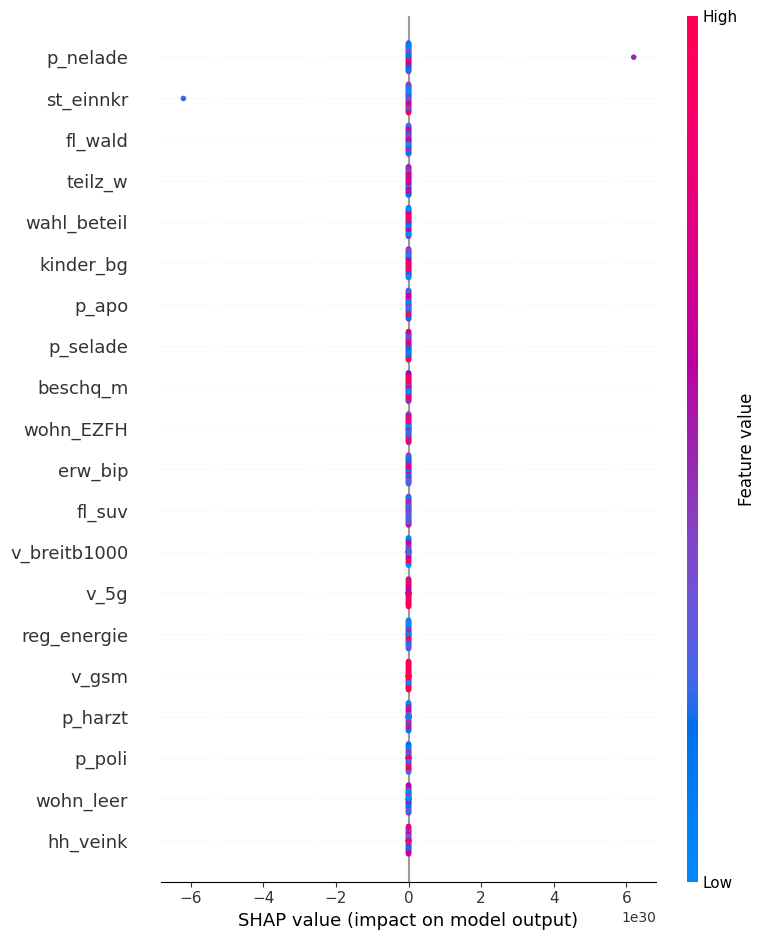

         feature  mean_abs_shap
5       p_nelade   1.239563e+29
10     st_einnkr   1.239563e+29
42       fl_wald   2.798637e+13
27       teilz_w   2.798637e+13
29   wahl_beteil   2.687874e+13
..           ...            ...
47     bev_18_65   2.318042e-04
92  Water_Bodies   1.013193e-04
91   Green_Areas   3.396654e-05
87    Gastronomy   0.000000e+00
81    p_ozmz_oev   0.000000e+00

[101 rows x 2 columns]


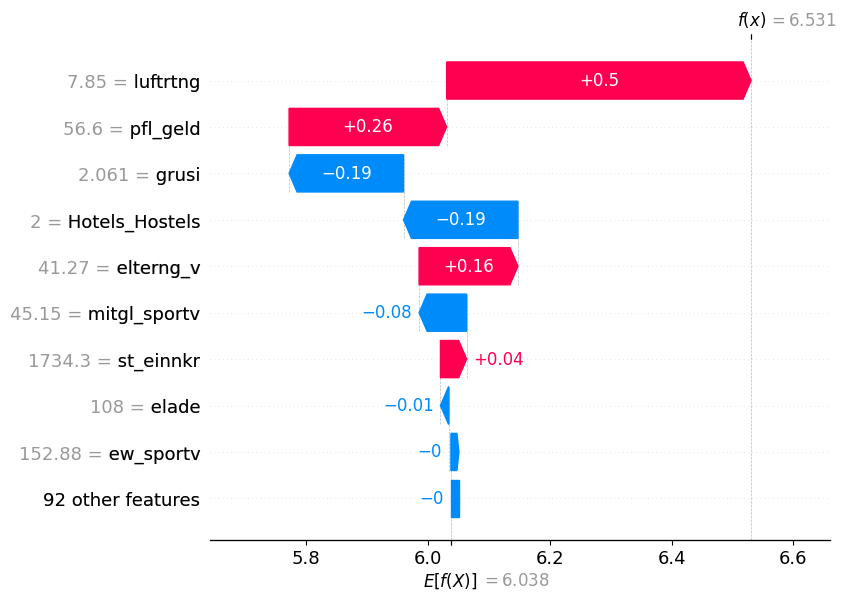

In [26]:
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1) Subsampling-Größen
bg_size, expl_size = 20, 50

# 2) Hintergrund und Erklärungs-Daten mit sämtlichen Features
bg_df   = train_df[feature_cols].sample(bg_size, random_state=42)
exp_df  = valid_df[feature_cols].sample(expl_size, random_state=42)

# 3) Modell-Wrapper korrigieren
def model_predict(x):
    # x kann np.ndarray oder pd.DataFrame sein
    if isinstance(x, np.ndarray):
        df = pd.DataFrame(x, columns=feature_cols)
    else:
        df = x
    # .predict() gibt direkt ein np.ndarray zurück
    return tabular_model.predict(df)

# 4) KernelExplainer initialisieren – nur Feature-Cols als Hintergrund
explainer = shap.KernelExplainer(
    model_predict,
    train_df[feature_cols].sample(20, random_state=42),
    feature_names=feature_cols
)

# 5) SHAP-Werte berechnen
shap_values = explainer.shap_values(
    valid_df[feature_cols].sample(50, random_state=42),
    nsamples=20
)

# 6) Beeswarm-Plot
shap.summary_plot(
    shap_values,
    valid_df[feature_cols].sample(50, random_state=42),
    feature_names=feature_cols,
    show=True
)

# 7) Mittlere absolute SHAP-Tabelle
import numpy as np, pandas as pd
mean_abs_shap = pd.DataFrame({
    "feature":      feature_cols,
    "mean_abs_shap": np.abs(shap_values).mean(axis=0)
}).sort_values("mean_abs_shap", ascending=False)
print(mean_abs_shap)

# 8) Waterfall-Plot fürs erste Sample
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=valid_df[feature_cols].sample(50, random_state=42).iloc[0],
        feature_names=feature_cols
    )
)